# GRAD 5203 Lecture on Machine Learning with Scikit-Learn

## David John Gagne II

*National Center for Atmospheric Research*

November 8, 2016

# About Me

* Advanced Study Program Postdoctoral Fellow at the National Center for Atmospheric Research
* Ph.D. in Meteorology from OU in 2016, M.S. in 2012, B.S. in 2010
* Research Focus: Developing and evaluating machine learning forecast systems for high impact weather 
* Hail and solar energy


# How are data analytics being used in meteorology?
  * Data Mining
    * Discover patterns relating weather data and non-meteorological factors
    * Example: amount of rain vs. election turnout
  * Data Fusion for Nowcasting
    * Merge data from different observation sources (e.g., radar, satellite, surface) 
    * Estimate a weather property of interest
  * Numerical Weather Prediction (NWP) Model Post-Processing
    * Correct for sysematic biases in NWP model output
    * Predict quantities not tracked or resolved by NWP models

# First Example: Hail Forecasting

* Large hail causes billions of dollars in property damage every year
* Advanced warning about hail may allow people to protect some property
* How to forecast hail?
  * Identify atmospheric conditions associated with large hail before storms form
  * When storms form, identify those containing hail
* Data sources:
  * **Soundings**, NWP model output, radar

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.calibration import calibration_curve
from datetime import datetime, timedelta
import os
%matplotlib inline

# Data: Sounding Analog Retrieval System (SARS)
* Database of soundings associated with large hail
* Created by the National Weather Service [Storm Prediction Center](http://www.spc.noaa.gov/publications/jewell/sars.pdf)
* Given a current sounding, find which soundings are close matches (analogs)
* Task: develop a machine learning version of SARS for Hail

![Alt text](http://sharppy.github.io/SHARPpy/sharppy.png)

In [3]:
hail_data = pd.read_csv("sars_hail.txt", sep="\t")
print(hail_data.columns)
hail_objects = pd.read_csv("hail_objects.csv")

Index([u'DATE/RAOB', u' ELEV', u'REPORT', u'MUCAPE', u'MUMR', u'500TEMP',
       u'300 T', u'7-5LR', u'5-3 LR', u'0-3SH', u'0-6SH', u'0-9SH', u'SRH3',
       u'SHIP', u'MODELb'],
      dtype='object')


In [3]:
hail_objects

,Object,Size
0,Marble/Moth ball,0.50
1,Penny,0.75
2,Nickel,0.88
3,Quarter,1.00
4,Half Dollar,1.25
5,Ping pong,1.50
6,Golf ball,1.75
7,Hen egg/Lime,2.00
8,Tennis ball,2.50
9,Baseball,2.75


## Hail Report Biases
* Reports of hail diameter are collected from the public by the National Weather Service
* Observers are encouraged to measure the diameter of the hail
* But often size is estimated based on comparisons with common objects
* Result: under-reporting of size categories with no object

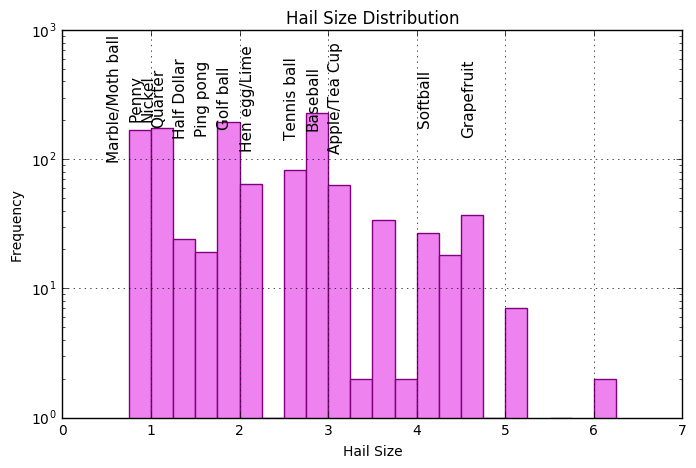

In [4]:
hail_data.hist("REPORT", bins=np.arange(0, 7, 0.25), figsize=(8, 5), color="violet", edgecolor="purple")
plt.xlabel("Hail Size")
plt.ylabel("Frequency")
plt.title("Hail Size Distribution")
for r in hail_objects.index:
    plt.text(hail_objects.loc[r,"Size"], 300, hail_objects.loc[r,"Object"], 
             rotation=90, ha="left", va="center", fontsize=11)
ax = plt.gca()
ax.set_yscale("log")

[['95052300' 'DDC']
 ['91051100' 'MAF']
 ['97061700' 'OUN']
 ..., 
 ['97082200' 'ILN']
 ['98062500' 'JAN']
 ['98081000' 'SHV']]


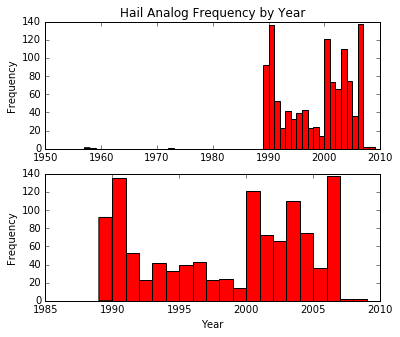

In [51]:
date_raob = np.vstack(hail_data["DATE/RAOB"].str.split(".").values)
print(date_raob)
date_list = [datetime.strptime(d, "%y%m%d%H") for d in date_raob[:, 0]]
date_list = [datetime(d.year-100, d.month, d.day) if d.year > 2016 else d for d in date_list]
hail_data["date"] = pd.DatetimeIndex(date_list)
hail_data["raob"] = date_raob[:, 1]
plt.figure(figsize=(6, 5))
plt.subplot(2,1,1)
plt.hist(pd.DatetimeIndex(hail_data["date"]).year, bins=np.arange(1957, 2010), color="red")
plt.ylabel("Frequency")
plt.title("Hail Analog Frequency by Year")
plt.subplot(2,1,2)
plt.hist(pd.DatetimeIndex(hail_data["date"]).year, bins=np.arange(1989, 2010), color="red")
plt.xlabel("Year")
plt.ylabel("Frequency")


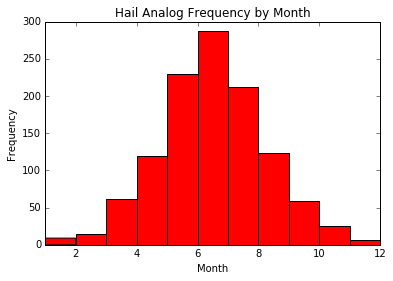

In [58]:
plt.hist(pd.DatetimeIndex(hail_data["date"]).month, bins=np.arange(1, 13), color="red")
plt.xlim(1, 12)
plt.xlabel("Month")
plt.ylabel("Frequency")
plt.title("Hail Analog Frequency by Month")

In [30]:
hail_data["raob"].unique()

array(['DDC', 'MAF', 'OUN', 'LZK', 'HON', 'BIS', 'RAP', 'LBF', 'TFX',
       'TOP', 'IAD', 'JAN', 'SEP', 'OVN', 'AMA', 'GTF', 'BRO', 'FNT',
       'INL', 'GSO', 'FWD', 'SHV', 'SGF', 'DNR', 'ILX', 'GGW', 'MHX',
       'BNA', 'FFC', 'FTD', 'DAY', 'DVN', 'BMX', 'OAX', 'ABR', 'RNK',
       'STC', 'GRB', 'UNR', 'PBI', 'CKL', 'HAT', 'TBW', '1M1', 'YRM',
       'LMN', 'SIL', 'DEN', 'OKX', 'UMN', 'GGG', 'DRT', 'CRP', 'WAL',
       'SSM', 'AHN', 'PIA', 'OMA', 'FWH', 'CHS', 'MPX', 'DTX', 'TLH',
       'LCH', 'CAR', 'AYS', 'ALB', 'PAH', 'XMR', 'EPZ', 'JAX', 'BUF',
       'APX', 'PIT', 'ELP', 'MFL', 'ABQ', 'TUS', 'LIX', 'DRA', 'ILN',
       'SLC', 'FGZ', 'BOI', 'PHX', 'NKX', 'HTS', 'VCT', 'OTX', 'GYX',
       'OAK', 'GJT', 'ACY', 'SLI'], dtype=object)

In [60]:
train = hail_data.sample(frac=0.7, random_state=404)
test = hail_data.drop(train.index)

In [61]:
input_cols = np.array(['MUCAPE', 'MUMR', '500TEMP', '300 T', '7-5LR', '5-3 LR', '0-3SH', '0-6SH', '0-9SH', 'SRH3'])
test_col = "REPORT"
size_threshold = 2
models = [RandomForestClassifier(n_estimators=100, max_features="sqrt"),
         LogisticRegression(penalty="l1")]
model_names = np.array(["Random Forest",
                        "Logistic Regression"])
for model in models:
    model.fit(train[input_cols], np.where(train[test_col] >= size_threshold, 1, 0))


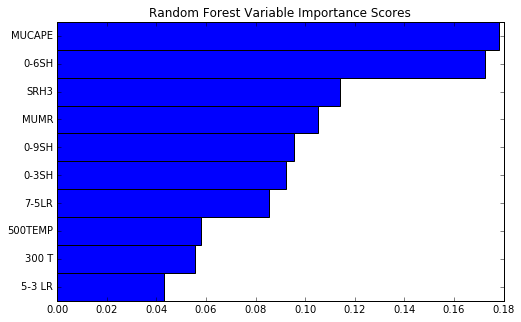

In [77]:
feature_ranking = models[0].feature_importances_.argsort()
plt.figure(figsize=(8, 5))
plt.barh(np.arange(feature_ranking.size), models[0].feature_importances_[feature_ranking], 1)
plt.yticks(np.arange(feature_ranking.size) + 0.5, input_cols[feature_ranking])
plt.title("Random Forest Variable Importance Scores")

In [63]:
for i, input_name in enumerate(input_cols):
    print(input_name, models[1].coef_[0,i])

('MUCAPE', 0.0015601919291492248)
('MUMR', -0.25627476455434584)
('500TEMP', -0.039500269314110908)
('300 T', 0.0087766395094079179)
('7-5LR', -0.0054057325634018607)
('5-3 LR', -0.14443308390905546)
('0-3SH', 0.092027810134274773)
('0-6SH', 0.086884417095782471)
('0-9SH', 0.028918603500859393)
('SRH3', 0.00015086715624670243)


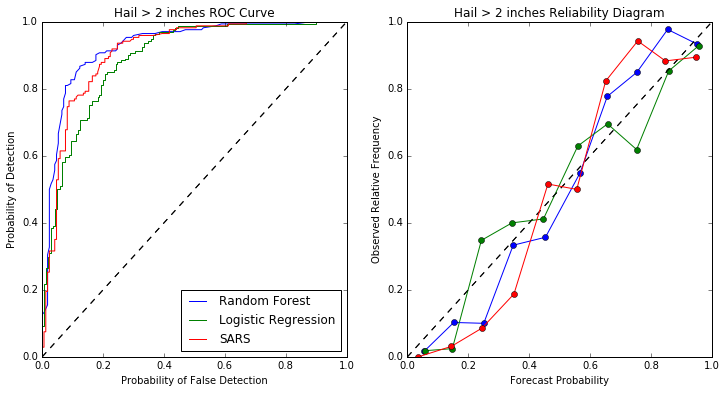

In [89]:
test_results = pd.DataFrame(columns=model_names, index=test.index, dtype=float)
test_labels = np.where(test[test_col] >= size_threshold, 1, 0)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
for m, model in enumerate(models):
    test_results[model_names[m]] = model.predict_proba(test[input_cols])[:, 1]
    pofd, pod, prob_thresh = roc_curve(test_labels, test_results[model_names[m]], pos_label=1)
    prob_true, prob_pred = calibration_curve(test_labels, test_results[model_names[m]], n_bins=10)
    ax1.plot(pofd, pod, label=model_names[m])
    ax2.plot(prob_pred, prob_true, marker='o', label=model_names[m])
    ax1.plot(np.arange(0, 1.1, .1),np.arange(0, 1.1, .1), 'k--')
    ax2.plot(np.arange(0, 1.1, .1),np.arange(0, 1.1, .1), 'k--')
pofd, pod, prob_thresh = roc_curve(test_labels, sars_test_probs, pos_label=1)
prob_true, prob_pred = calibration_curve(test_labels, sars_test_probs, n_bins=10)
ax1.plot(pofd, pod, label="SARS")
ax2.plot(prob_pred, prob_true, marker='o', label="SARS")

ax1.legend(loc=4)
ax1.set_xlabel("Probability of False Detection")
ax1.set_ylabel("Probability of Detection")
ax1.set_title("Hail > 2 inches ROC Curve")
ax2.set_xlabel("Forecast Probability")
ax2.set_ylabel("Observed Relative Frequency")
ax2.set_title("Hail > 2 inches Reliability Diagram")
#plt.plot(prob_thresh, pod - pofd)

In [80]:
def hail(hail_database, mumr, mucape, h5_temp, lr, shr6, shr9, shr3, srh):
    '''
    The SARS Hail database was provided by Ryan Jewell of the NOAA Storm
    Prediction Center in Norman, Oklahoma. This is a database of observed
    and model proximity analogue soundings to hail events.
    
    This function works by searching for matches to particular variables in 
    the database that have been attributed to hail events given a certain 
    range of uncertainty. The loose matches are used for statistics such as
    % significant hail matches, and are based on a looser criteria for
    matches. The analogues that get displayed are based on a tighter criteria
    for matches to insure that only quality matches are received. Ranges for
    loose and quality matches are semi-arbitrary, and were tuned by testing
    internally by SPC.
    
    The loose matches are based on the most unstable parcel mixing ratio (mumr),
    most unstable cape (mucape), 700-500mb labse rate (lr), 500mb temperature
    (h5_temp), 0-3km shear (shr3), 0-6km shear (shr6), and the 0-9km shear (shr9).
    
    The ranges for the loose matches are set as such:
        mumr: +/- 2.0 g/kg
        mucape: +/- 30% J/kg
        lr: +/- 2.0 C/km
        h5_temp: +/- 9.0 C
        shr6: +/- 12 m^2/s^2
        shr9: +/- 22 m^2/s^2
        shr3: +/- 10 m^2/s^2
    
    The quality matches use the fields described in the loose matches, plus the
    0-3km Storm Relative Helicity (srh). The bounds for the search for quality 
    matches is much more strict that the loose matches.
    
    The ranges for the quality matches are set as such:
        mumr: +/- 2.0 g/kg
        mucape < 500 J/kg: +/- 50% J/kg
        mucape < 2000 J/kg: +/- 25% J/kg
        mucape >= 2000 J/kg: +/- 20% J/kg
        lr: +/- 0.4 C/km
        h5_temp: +/- 1.5 C/km
        shr6: +/- 6 m^2/s^2
        shr9: +/- 15 m^2/s^2
        shr3: +/- 8 m^2/s^2
        srh < 50 m^2/s^2: +/- 25 m^2/s^2
        srh >= 50 m^2/s^2: +/- 50% m^2/s^2
    
    Parameters
    ----------
    mumr - most unstable parcel mixing ratio (g/kg)
    mucape - most unstable CAPE (J/kg)
    h5_temp - 500 mb temperature (C)
    lr - 700-500 mb lapse rate (C/km)
    shr6 - 0-6 km shear (m/s)
    shr9 - 0-9 km shear (m/s)
    shr3 - 0-3 km shear (m/s)
    srh - 0-3 Storm Relative Helicity (m2/s2)
    
    Returns
    -------
    quality_match_dates (str) - dates of the quality matches
    quality_match_sizes (float) - hail sizes of the quality matches
    num_loose_matches (int) - number of loose matches
    num_sig_reports (int) - number of significant hail reports (>= 2 inches)
    prob_sig_hail (float) - SARS sig. hail probability
    
    '''
    ## open the file in the current directory with the name database_fn

    #Set range criteria for matching sounding
    # MU Mixing Ratio Ranges
    range_mumr = 2.0 # g/kg
    range_mumr_t1 = 2.0 # g/kg

    # MUCAPE Ranges (J/kg)
    range_mucape = mucape*.30
    if mucape < 500.:
        range_mucape_t1 = mucape * .50
    elif mucape >= 500. and mucape < 2000.:
        range_mucape_t1 = mucape * .25
    else:
        range_mucape_t1 = mucape * .20

    # 700-500 mb Lapse Rate Ranges
    range_lr = 2.0 # C/km
    range_lr_t1 = 0.4 # C/km

    # 500 mb temperature ranges
    range_temp = 9 # C
    range_temp_t1 = 1.5 # C

    # 0-6 km shear ranges
    range_shr6 = 12 # m/s
    range_shr6_t1 = 6 # m/s

    # 0-9 km shear ranges

    range_shr9 = 22 # m/s
    range_shr9_t1 = 15 # m/s

    # 0-3 km shear ranges
    range_shr3 = 10
    range_shr3_t1 = 8

    # 0-3 SRH Ranges
    range_srh = 100
    if srh < 50:
        range_srh_t1 = 25
    else:
        range_srh_t1 = srh * 0.5

    #Get database variables from the columns in the file and make them floats
    matmr = np.asarray(hail_database[:,4], dtype=float) # MU Mixing Ratio
    matcape = np.asarray(hail_database[:,3], dtype=float) # MUCAPE
    matlr = np.asarray(hail_database[:,7], dtype=float) # 700-500 mb lapse rate
    mattemp = np.asarray(hail_database[:,5], dtype=float) # 500 mb temp
    matshr6 = np.asarray(hail_database[:,10], dtype=float) # 0-6 shear
    matshr9 = np.asarray(hail_database[:,11], dtype=float) # 0-9 shear
    matshr3 = np.asarray(hail_database[:,9], dtype=float) # 0-3 shear
    matsrh = np.asarray(hail_database[:,12], dtype=float) # 0-3 SRH

    # Find the loose matches using the ranges set above
    loose_match_idx = np.where((mumr >= (matmr - range_mumr)) & (mumr <= (matmr + range_mumr)) & \
                               (mucape >= (matcape - range_mucape)) & (mucape <= (matcape + range_mucape)) & \
                               (lr >= (matlr - range_lr)) & (lr <= (matlr + range_lr)) & \
                               (h5_temp >= (mattemp - range_temp)) & (h5_temp <= (mattemp + range_temp)) & \
                               (shr6 >= (matshr6 - range_shr6)) & (shr6 <= (matshr6 + range_shr6)) & \
                               (shr9 >= (matshr9 - range_shr9)) & (shr9 <= (matshr9 + range_shr9)) & \
                               (shr3 >= (matshr3 - range_shr3)) & (shr3 <= (matshr3 + range_shr3)))[0]
    ## How many loose matches are there?
    num_loose_matches = float(len(loose_match_idx))
    ## What were the sizes of those matches?
    hail_sizes = np.asarray(hail_database[:,2], dtype=float)
    ## How many of them were significant (>2.0 in)?
    num_sig_reports = float(len(np.where(hail_sizes[loose_match_idx] >= 2.)[0]))

    ## Calculate the Probability of significant hail - must make sure
    ## loose matches are > 0 to prevent division by 0.
    if num_loose_matches > 0 and mucape > 0:
        prob_sig_hail = num_sig_reports / num_loose_matches
        # Calculate the average hail size from the loose matches
        avg_hail_size = np.mean(hail_sizes[loose_match_idx])
    else:
        prob_sig_hail = 0

    # Find the quality matches
    quality_match_idx = np.where((mumr >= (matmr - range_mumr_t1)) & (mumr <= (matmr + range_mumr_t1)) & \
                               (mucape >= (matcape - range_mucape_t1)) & (mucape <= (matcape + range_mucape_t1)) & \
                               (lr >= (matlr - range_lr_t1)) & (lr <= (matlr + range_lr_t1)) & \
                               (h5_temp >= (mattemp - range_temp_t1)) & (h5_temp <= (mattemp + range_temp_t1)) & \
                               (shr6 >= (matshr6 - range_shr6_t1)) & (shr6 <= (matshr6 + range_shr6_t1)) & \
                               (shr9 >= (matshr9 - range_shr9_t1)) & (shr9 <= (matshr9 + range_shr9_t1)) & \
                               (shr3 >= (matshr3 - range_shr3_t1)) & (shr3 <= (matshr3 + range_shr3_t1)) & \
                               (srh >= (matsrh - range_srh_t1)) & (srh <= (matsrh + range_srh_t1)))[0]

    quality_match_dates = hail_database[quality_match_idx,0]
    quality_match_sizes = np.asarray(hail_database[quality_match_idx,2], dtype=float)

    # This filtering was in the sars.f file so the graphical output wasn't overrun by historical quality matches
    max_quality_matches = 15
    quality_match_dates = quality_match_dates[:max_quality_matches]
    quality_match_sizes = quality_match_sizes[:max_quality_matches]

    return quality_match_dates, quality_match_sizes, num_loose_matches, num_sig_reports, prob_sig_hail

In [86]:
train_text = train.astype("str").values
print(train.columns)
# mumr, mucape, h5_temp, lr, shr6, shr9, shr3, srh
sars_test_probs = np.zeros(test.shape[0])
for r, row in enumerate(test.index):
    sars_test_probs[r] = hail(train_text, *test.loc[row, ["MUMR", "MUCAPE", "500TEMP", "7-5LR", "0-6SH", "0-9SH", "0-3SH", "SHR"]].tolist())[-1]

Index([u'DATE/RAOB', u' ELEV', u'REPORT', u'MUCAPE', u'MUMR', u'500TEMP',
       u'300 T', u'7-5LR', u'5-3 LR', u'0-3SH', u'0-6SH', u'0-9SH', u'SRH3',
       u'SHIP', u'MODELb', u'date', u'raob'],
      dtype='object')
